*Include this to prevent kernel reload during early stages of code development.*

In [ ]:
%load_ext autoreload
%autoreload 2

#### Imports

* Python libraries.
* Models for the NACA airfoil and the panel discretization. 

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from naca import NacaGenerator
from panel import Panel

# Vortex Panel Method

The vortex panel method seeks to obtain the lift coefficient for a *closed* airfoil. 

The method has two intrinsic parts. At the beginning one must account for the geometrical properties of the airfoil, $\vec{x}$, which will determine how each vortex will interact with the others. Next, one has to account for the incoming flow, in particular for its incidence angle $\alpha$. 


**Detailed breakdown**
1. Compute airfoil coordinates.
1. Assemble panels:
  * Location of control point.
  * Length of the panel.
  * Normal and line vectors.
  * Angle w.r.t. to x-axis.
1. Build normal velocity matrices $C_{n,i}$.
1. Build tangential velocity matrices $C_{t,i}$.
1. Set up linear operator $L(z) = A(\vec{x})z$ to account for geometry.
1. Set up vector $b(\alpha)$ to account for flow conditions.
1. Solve via GMRES iterative method, $L(x) = b(\alpha, \vec{x})$.
1. Compute relevant physical quantities:
  * Pressure distribution $C_p$.
  * Lift coefficient via integration $C_l$. 
---

## Problem parameters

* NACA 4-digit airfoil.
* Number of x points.
* AoA in **degrees**.

In [4]:
NACA = '2412'
NUM_POINTS_X = 100
ALPHA = 0.0 # DEG

## Airfoil geometry

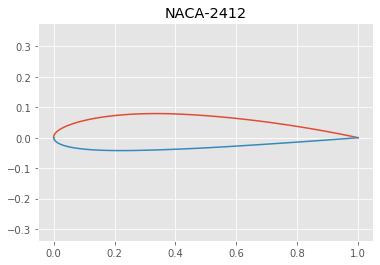

In [5]:
def generate_airfoil(NACA, NUM_POINTS_X):
    airfoil = NacaGenerator(naca=NACA)

    airfoil.generate_cosine_distribution(N=NUM_POINTS_X);
    airfoil.generate_naca();
    
    return airfoil

airfoil = generate_airfoil(NACA, NUM_POINTS_X=NUM_POINTS_X)

airfoil.plot()

Get the $(x,y)$ coordinates of the boundary points in the **clockwise** direction, starting at the trailing-edge. 

In [6]:
x, y = airfoil.clockwise_naca()

# Enforce actual zeros
x = np.where(np.isclose(x, 0), 0, x)
y = np.where(np.isclose(y, 0), 0, y)

### Panel generation

Build a list of panels in the **clockwise** direction. 

In [7]:
N_b = len(x)

x_c   = np.zeros(N_b - 1)
y_c   = np.zeros(N_b - 1)
S     = np.zeros(N_b - 1)
theta = np.zeros(N_b - 1)
normals = []
lines = []

idx = 0
for xs, xe, ys, ye in zip(x, x[1:], y, y[1:]):
    
    # Control points
    x_c[idx] = (xs + xe) / 2.0
    y_c[idx] = (ys + ye) / 2.0
    
    # Length
    _S     = (xe - xs)**2.0 + (ye - ys)**2.0
    S[idx] = np.sqrt(_S) 
    
    # Angle
    theta[idx] = np.arctan2(ye - ys , 
                            xe - xs)
    
    #########
    # Vectors
    #########
    # Normal
    normal = np.array([-(ye-ys), (xe-xs)])
    normal = normal / np.linalg.norm(normal)
    
    normals.append(normal)
    
    # Line
    line = np.array([(xe-xs), (ye-ys)])
    line = line / np.linalg.norm(line)
    
    lines.append(line)
    
    # Update index counter
    idx += 1

normals = np.array(normals)
lines = np.array(lines)

## Build normal and tangential matrices. 

In [8]:
Cn1 = np.zeros(shape = (N_b-1, N_b-1))
Cn2 = np.zeros(shape = (N_b-1, N_b-1))

Ct1 = np.zeros(shape = (N_b-1, N_b-1))
Ct2 = np.zeros(shape = (N_b-1, N_b-1))

for i in range(N_b-1):
    for j in range(N_b-1):
    
        # Fill-in diagonals
        if i == j:
            
            Cn1[i,j] = -1
            Cn2[i,j] =  1 
            
            Ct1[i,j] = 0.5 * np.pi
            Ct2[i,j] = 0.5 * np.pi
        
        else:
            
            dx = x_c[i] - x[j]
            dy = y_c[i] - y[j]
            
            A = - dx * np.cos(theta[j]) - dy * np.sin(theta[j])
            E =   dx * np.sin(theta[j]) - dy * np.cos(theta[j])
            
            B = dx**2.0 + dy**2.0
            
            C = np.sin(theta[i] - theta[j])
            D = np.cos(theta[i] - theta[j])
            
            F = np.log(1.0 + ((S[j])**2.0 + (2.0 * A * S[j])) / B)
            
            G = np.arctan2((E*S[j]) , (B + A * S[j]))
            
            P = (dx * np.sin(theta[i] - 2.0 * theta[j])) + (dy * np.cos(theta[i] - 2.0 * theta[j]))
            Q = (dx * np.cos(theta[i] - 2.0 * theta[j])) - (dy * np.sin(theta[i] - 2.0 * theta[j]))
            
            # Normal matrix
            Cn2[i,j] = D + ((0.5 * Q * F) / S[j]) - ((A*C + D*E) * (G / S[j]))
            Cn1[i,j] = 0.5*D*F + C*G - Cn2[i,j]
            
            # Tangential matrix
            Ct2[i,j] = C + ((0.5 * P * F) / S[j]) + ((A*D - C*E) * (G / S[j]))
            Ct1[i,j] = 0.5*C*F - D*G - Ct2[i,j]

In [9]:
def summand(i, j, gamma):
    
    return Cn1[i,j] * gamma[j] + Cn2[i,j] * gamma[j+1]

In [10]:
def system_of_equations(gamma):
        
    # Prepare gammas
    result = np.zeros_like(gamma)
    
    # Matrix-product implementation
    for i in range(len(result)-1):
        for j in range(len(gamma)-1):
            
            result[i] += summand(i, j, gamma)
            
    # Compatibility condition at the end
    result[-1] = gamma[0] + gamma[-1]
    
    return result

## Airflow solution

So far, everything depends on the geometry. Now we are going to compute the RHS, which depends on the incidence angle and the geometry. 

In [11]:
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import gmres

ModuleNotFoundError: No module named 'scipy'

An iterative linear operator will be used. This will not affect our solution, but will simplify the way we build the matrix. 

In [ ]:
A = LinearOperator((N_b, N_b), matvec=system_of_equations)
A

In [ ]:
ALPHA = np.deg2rad(ALPHA)

# RHS
b = np.zeros(N_b)

for idx in range(len(b)-1):
    b[idx] = np.sin(theta[idx] - ALPHA)

# Kutta condition
b[-1] = 0.0

In [ ]:
ITERATIONS_MAX     = 10000
ITERATIONS_RESTART = ITERATIONS_MAX

In [12]:
gammas, info = gmres(A, b, 
                     x0      = np.ones(N_b), 
                     restart = ITERATIONS_RESTART, 
                     maxiter = ITERATIONS_MAX, 
                     tol     = 1e-8,
                     atol    = 1e-8) 

NameError: name 'gmres' is not defined

In [530]:
info

0

In [531]:
def summand_tangential(i, j, gamma):
    
    return Ct1[i][j] * gamma[j] + Ct2[i][j] * gamma[j+1]

In [532]:
def compute_velocity(gamma):
    
    # Prepare gammas
    result = np.zeros(len(gamma)-1)
    
    # Matrix-product implementation
    for i in range(len(result)):
        for j in range(len(gamma)-1):
            
            result[i] += summand_tangential(i, j, gamma)
    
    return np.cos(theta - ALPHA) + result

In [533]:
def compute_pressure_distribution(gamma):
    
    velocity = compute_velocity(gamma)
    
    return 1.0 - np.power(velocity, 2.0)

In [534]:
def compute_lift(gamma):
    
    cp = compute_pressure_distribution(gamma)
    vec_j = np.array([0, 1])
     
    return np.sum(-cp * np.dot(normals, vec_j) * S)

In [535]:
compute_lift(gammas)

0.25830828966047453

Text(0.5, 0, '$x$')

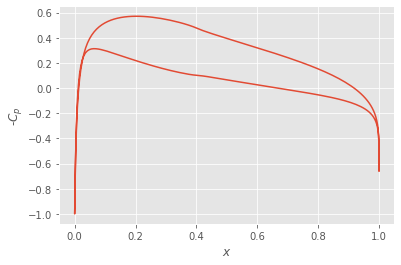

In [536]:
cp = compute_pressure_distribution(gammas)

plt.plot(x_c, -cp)
plt.ylabel('-$C_p$')
plt.xlabel('$x$')

Text(0.5, 0, '$x$')

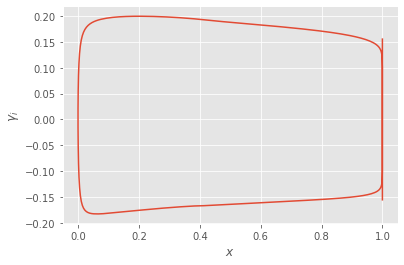

In [537]:
plt.plot(x, gammas)
plt.ylabel('$\gamma_i$')
plt.xlabel('$x$')